In [29]:
import re

import wandb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerTuple
from scipy.stats import bootstrap
from collections import defaultdict


def nested_dict():
    return defaultdict(nested_dict)

def ci_95(data):
    if len(data) < 2:
        return (-1, -1)
    res = bootstrap((np.array(data),), np.mean, confidence_level=0.95, n_resamples=1000, method="basic")
    return res.confidence_interval.low.astype(np.int64), res.confidence_interval.high.astype(np.int64)

def bootstrap_mean_ci(trajectories, n_bootstraps=1000, ci=95):
    """
    Calculates the mean and confidence interval for a set of trajectories.

    Args:
        trajectories (np.ndarray): A 2D numpy array where each row is a trajectory.
                                   Shape: (n_trajectories, n_timepoints).
        n_bootstraps (int): The number of bootstrap samples to generate.
        ci (int): The desired confidence interval in percent.

    Returns:
        tuple: A tuple containing:
            - mean_trajectory (np.ndarray): The mean trajectory.
            - ci_lower (np.ndarray): The lower bound of the confidence interval.
            - ci_upper (np.ndarray): The upper bound of the confidence interval.
    """
    n_trajectories, n_timepoints = trajectories.shape
    bootstrap_means = np.zeros((n_bootstraps, n_timepoints))

    for i in range(n_bootstraps):
        indices = np.random.choice(n_trajectories, size=n_trajectories, replace=True)
        bootstrap_sample = trajectories[indices, :]
        bootstrap_means[i, :] = np.mean(bootstrap_sample, axis=0)

    mean_trajectory = np.mean(trajectories, axis=0)

    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile

    ci_lower, ci_upper = np.percentile(
        bootstrap_means, [lower_percentile, upper_percentile], axis=0
    )

    return mean_trajectory, ci_lower, ci_upper

In [2]:
group_map = {}
env_translation = {
    "Pendulum": "BalancePendulum",
    "Quadrotor": "BalanceQuadrotor",
    "Energy System": "LoadBalanceHousehold"
}
safeguard_translation = {
    "No Safeguard": "NP",
    "Boundary Projection Base": "P",
    "Boundary Projection Regularised": "P",
    "Ray Mask Base": "ZRP-Lin",
    "Ray Mask Regularised": "ZRP-Lin",
    "Ray Mask Passthrough": "ZRP-Lin-PT",
    "Hyperbolic Ray Mask Base": "ZRP-Tanh",
    "Hyperbolic Ray Mask Regularised": "ZRP-Tanh",
    "Ray Mask Orthogonal": "ORP-Lin"
}
safeguard_table = {
    "Boundary Projection Base": ("BP", "Base"),
    "Boundary Projection Regularised": ("BP", "Regularised"),
    "Ray Mask Base": ("RM", "Base"),
    "Ray Mask Regularised": ("RM", "Regularised"),
    "Ray Mask Passthrough": ("RM", "Passthrough"),
    "Hyperbolic Ray Mask Base": ("HRM", "Base"),
    "Hyperbolic Ray Mask Regularised": ("HRM", "Regularised"),
}

algorithms = ["SHAC", "SAC", "PPO"]
for env in env_translation.keys():
    for algo in algorithms:
        for safeguard in safeguard_translation.keys():
            translation = safeguard_translation[safeguard]
            if env == "Energy System" and translation == "P":
                translation = translation.replace("P", "BP")
            elif env == "Energy System" and "ZRP" in translation:
                translation = translation.replace("ZRP", "ZRM")
            elif env == "Energy System" and "ORP" in translation:
                translation = translation.replace("ORP", "ORM")

            key = env_translation[env] + "-" + translation + "-" + algo
            key += "" if "Regularised" not in safeguard else "-Reg"

            group_map[key] = (env, algo, safeguard)

stuck_runs = {
    "Pendulum": {
        "SHAC": {
            "No Safeguard": ["likely-paper-5140"],
            "Boundary Projection Base": ["clean-universe-5155", "trim-shadow-5153"],
            "Boundary Projection Regularised": ["turtle-brulee-5032"],
            "Ray Mask Base": [],
            "Ray Mask Regularised": [],
            "Ray Mask Passthrough": ["happy-shadow-5213", "boysenberry-strudel-5040"],
            "Hyperbolic Ray Mask Base": ["different-terrain-5205"],
            "Hyperbolic Ray Mask Regularised": [],
            "Ray Mask Orthogonal": []
        },
        "PPO": {
            "No Safeguard": [],
            "Boundary Projection Base": [],
            "Ray Mask Base": [],
        },
        "SAC": {
            "No Safeguard": [],
            "Boundary Projection Base": [],
            "Ray Mask Base": [],
        }},
    "Quadrotor": {
        "SHAC": {
            "No Safeguard": [],
            "Boundary Projection Base": [],
            "Boundary Projection Regularised": [],
            "Ray Mask Base": [],
            "Ray Mask Regularised": [],
            "Ray Mask Passthrough": ["comfy-gorge-5215"],
            "Hyperbolic Ray Mask Base": [],
            "Hyperbolic Ray Mask Regularised": [],
            "Ray Mask Orthogonal": []
        },
        "PPO": {
            "No Safeguard": [],
            "Boundary Projection Base": [],
            "Ray Mask Base": [],
        },
        "SAC": {
            "No Safeguard": [],
            "Boundary Projection Base": [],
            "Ray Mask Base": [],
        }},
    "Energy System": {
        "SHAC": {
            "No Safeguard": [],
            "Boundary Projection Base": [],
            "Boundary Projection Regularised": [],
            "Ray Mask Base": [],
            "Ray Mask Regularised": [],
            "Ray Mask Passthrough": [],
            "Hyperbolic Ray Mask Base": [],
            "Hyperbolic Ray Mask Regularised": [],
            "Ray Mask Orthogonal": []
        },
        "PPO": {
            "No Safeguard": [],
            "Boundary Projection Base": [],
            "Ray Mask Base": [],
        },
        "SAC": {
            "No Safeguard": [],
            "Boundary Projection Base": [],
            "Ray Mask Base": [],
        }},
}

In [3]:
api = wandb.Api()

entity = "tim-walter-tum"
project = "Safe Differentiable Reinforcement Learning"

runs = api.runs(f"{entity}/{project}")

In [10]:
results = nested_dict()
timing_results = nested_dict()

for run in api.runs(f"{entity}/{project}"):
    try:
        group = run.group
        if group not in group_map:
            continue
        env, algo, safeguard = group_map[group]
        if run.name in stuck_runs[env][algo][safeguard]:
            continue
        if "Timing" in run.name:
            timing_results[env][algo][safeguard] = run.summary['_wandb']['runtime']
        else:
            rewards = run.history(keys=["eval/Episodic Reward"])["eval/Episodic Reward"].dropna().values
            steps = run.history(keys=["eval/Episodic Reward"])["_step"].dropna().values

            threshold = rewards[-1] * 0.95 if rewards[-1] > 0 else rewards[-1] * 1.05
            idx = np.where(rewards >= threshold)[0]
            nr_steps = steps[idx[0]] if len(idx) > 0 else steps[-1]

            if len(results[env][algo][safeguard]) == 0:
                results[env][algo][safeguard] = {"nr_steps": [], "reward": np.array([rewards])}
            else:
                if results[env][algo][safeguard]["reward"].shape[1] != len(rewards):
                    results[env][algo][safeguard]["reward"] = np.vstack([results[env][algo][safeguard]["reward"], rewards[:-1]])
                else:
                    results[env][algo][safeguard]["reward"] = np.vstack([results[env][algo][safeguard]["reward"], rewards])

            results[env][algo][safeguard]["nr_steps"] += [nr_steps]
            results[env][algo][safeguard]["steps"] = steps
    except Exception as e:
        print(e)
        print(run.group)
        print(run.name)

'NoneType' object is not subscriptable
LoadBalanceHousehold-ZRM-Lin-PT-SHAC
smart-bee-5755
all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 76 and the array at index 1 has size 5
LoadBalanceHousehold-ZRM-Tanh-SHAC-Reg
eager-firefly-6073


In [11]:
#Table 2
print(r"""
\begin{table*}
  \centering
  \caption{Comparison of learning algorithms in unsafe training.}
  \label{tab:unsafe}
  \begin{tabular}{l r r r r r}
    \toprule
    \multirow{2}{*}{Algorithm} & \multicolumn{2}{c}{\# Step} & \multicolumn{2}{c}{Reward} & \multirow{2}{*}{\# Stuck} \\
    & Mean & 95\% CI & Mean & 95\% CI & \\""")

for env in results.keys():
    print(rf"""
    \midrule
    \multicolumn{{6}}{{c}}{{{env}}}             \\
    \\ [-0.5em]
    """)
    for algo in algorithms:
        res = results[env][algo]["No Safeguard"]

        mean_steps = int(np.mean(res["nr_steps"]))
        low_steps, high_steps = ci_95(res["nr_steps"])

        mean_reward = int(np.mean(res["reward"][:, -1]))
        low_reward, high_reward = ci_95(res["reward"][:, -1])

        nr_stuck = len(stuck_runs[env][algo]["No Safeguard"])
        print(rf"""{algo} & {mean_steps} & [{low_steps}, {high_steps}] & {mean_reward} & [{low_reward}, {high_reward}] & {nr_stuck} \\""")
print(r"""    \bottomrule
  \end{tabular}
\end{table*}""")


\begin{table*}
  \centering
  \caption{Comparison of learning algorithms in unsafe training.}
  \label{tab:unsafe}
  \begin{tabular}{l r r r r r}
    \toprule
    \multirow{2}{*}{Algorithm} & \multicolumn{2}{c}{\# Step} & \multicolumn{2}{c}{Reward} & \multirow{2}{*}{\# Stuck} \\
    & Mean & 95\% CI & Mean & 95\% CI & \\

    \midrule
    \multicolumn{6}{c}{Pendulum}             \\
    \\ [-0.5em]
    
SHAC & 12800 & [10808, 15360] & -8 & [-8, -8] & 1 \\
SAC & 8513 & [6260, 10767] & -14 & [-16, -11] & 0 \\
PPO & 81600 & [81600, 81600] & -596 & [-1173, 421] & 0 \\

    \midrule
    \multicolumn{6}{c}{Quadrotor}             \\
    \\ [-0.5em]
    
SHAC & 20364 & [11558, 27520] & -157 & [-169, -140] & 0 \\
SAC & 80628 & [59595, 108172] & -1046 & [-1858, 113] & 0 \\
PPO & 80640 & [42560, 118720] & -1710 & [-2132, -1271] & 0 \\

    \midrule
    \multicolumn{6}{c}{Energy System}             \\
    \\ [-0.5em]
    
SHAC & 328680 & [124014, 497705] & -104339 & [-138017, -67980] & 0 \\
SAC & 

In [12]:
# Table 3
print(r"""
\begin{table*}
  \centering
  \caption{Comparison of learning algorithms in safeguarded training.}
  \label{tab:safe}
  \begin{tabular}{l r r r r r r}
    \toprule
    \multirow{2}{*}{Safeguard} & \multirow{2}{*}{Algorithm} & \multicolumn{2}{c}{\# Step} & \multicolumn{2}{c}{Reward} & \multirow{2}{*}{\# Stuck} \\
    & & Mean & 95\% CI & Mean & 95\% CI & \\""")

for env in results.keys():
    print(rf"""
    \midrule
    \midrule
    \multicolumn{{6}}{{c}}{{{env}}}             \\
    \\ [-0.5em]
    """)
    for short_safeguard in ["BP", "RM"]:
        if short_safeguard == "BP":
            safeguard = "Boundary Projection Base"
        else:
            safeguard = "Ray Mask Base"
            print(rf"""\midrule""")
        for algo in algorithms:
            res = results[env][algo][safeguard]
            try:
                mean_steps = int(np.mean(res["nr_steps"]))
                low_steps, high_steps = ci_95(res["nr_steps"])

                mean_reward = int(np.mean(res["reward"][:, -1]))
                low_reward, high_reward = ci_95(res["reward"][:, -1])

                nr_stuck = len(stuck_runs[env][algo][safeguard])
            except TypeError:
                pass
            print(rf"""{rf'\multirow{{3}}{{*}}{{{short_safeguard}}}' if algo =="SHAC" else ""} & {algo} & {mean_steps} & [{low_steps}, {high_steps}] & {mean_reward} & [{low_reward}, {high_reward}] & {nr_stuck} \\""")
print(r"""    \bottomrule
  \end{tabular}
\end{table*}""")


\begin{table*}
  \centering
  \caption{Comparison of learning algorithms in safeguarded training.}
  \label{tab:safe}
  \begin{tabular}{l r r r r r r}
    \toprule
    \multirow{2}{*}{Safeguard} & \multirow{2}{*}{Algorithm} & \multicolumn{2}{c}{\# Step} & \multicolumn{2}{c}{Reward} & \multirow{2}{*}{\# Stuck} \\
    & & Mean & 95\% CI & Mean & 95\% CI & \\

    \midrule
    \midrule
    \multicolumn{6}{c}{Pendulum}             \\
    \\ [-0.5em]
    
\multirow{3}{*}{BP} & SHAC & 23360 & [18560, 28480] & -8 & [-8, -8] & 2 \\
 & SAC & 2504 & [2504, 2504] & -1083 & [-1104, -1061] & 0 \\
 & PPO & 80240 & [78880, 82960] & -10 & [-10, -9] & 0 \\
\midrule
\multirow{3}{*}{RM} & SHAC & 27392 & [20992, 32768] & -8 & [-8, -8] & 0 \\
 & SAC & 2504 & [2504, 2504] & -424 & [-464, -383] & 0 \\
 & PPO & 76160 & [72080, 80240] & -12 & [-12, -11] & 0 \\

    \midrule
    \midrule
    \multicolumn{6}{c}{Quadrotor}             \\
    \\ [-0.5em]
    
\multirow{3}{*}{BP} & SHAC & 45683 & [14860, 73781] & 

In [13]:
# Table 4
print(r"""
\begin{table}
  \centering
  \caption{Number of non-convergent runs for the various safeguards.}
  \label{tab:excluded}
  \begin{tabular}{l l r r r}
    \toprule
    \multicolumn{2}{l}{\multirow{2}{*}{Safeguard}} & \multicolumn{3}{c}{\# Stuck} \\
     & & Pen & Quad & ES \\""")
for safeguard in safeguard_translation.keys():
    if safeguard == "No Safeguard" or safeguard == "Ray Mask Orthogonal":
        continue
    base, mod = safeguard_table[safeguard]
    nr_stuck_pen = len(stuck_runs["Pendulum"]["SHAC"][safeguard])
    nr_stuck_quad = len(stuck_runs["Quadrotor"]["SHAC"][safeguard])
    nr_stuck_es = len(stuck_runs["Energy System"]["SHAC"][safeguard])
    print(rf"""{r'\midrule' if mod == "Base" else ''}
    {rf'\multirow{{{2 if base == "BP" or base == "HRM" else 3}}}{{*}}{{{base}}}' if mod =="Base" else ''} & {mod} & {nr_stuck_pen} & {nr_stuck_quad} & {nr_stuck_es} \\""")
print(r"""    \bottomrule
  \end{tabular}
\end{table}""")


\begin{table}
  \centering
  \caption{Number of non-convergent runs for the various safeguards.}
  \label{tab:excluded}
  \begin{tabular}{l l r r r}
    \toprule
    \multicolumn{2}{l}{\multirow{2}{*}{Safeguard}} & \multicolumn{3}{c}{\# Stuck} \\
     & & Pen & Quad & ES \\
\midrule
    \multirow{2}{*}{BP} & Base & 2 & 0 & 0 \\

     & Regularised & 1 & 0 & 0 \\
\midrule
    \multirow{3}{*}{RM} & Base & 0 & 0 & 0 \\

     & Regularised & 0 & 0 & 0 \\

     & Passthrough & 2 & 1 & 0 \\
\midrule
    \multirow{2}{*}{HRM} & Base & 1 & 0 & 0 \\

     & Regularised & 0 & 0 & 0 \\
    \bottomrule
  \end{tabular}
\end{table}


In [14]:
# Table 5
print(r"""
\begin{table*}
  \centering
  \caption{Comparison of the safe centre approximations.}
  \label{tab:orp}
  \begin{tabular}{l r r r r r}
    \toprule
    \multirow{2}{*}{Approximation} & \multicolumn{2}{c}{\# Step} & \multicolumn{2}{c}{Reward} & \multirow{2}{*}{\# Stuck} \\
    & Mean & 95\% CI & Mean & 95\% CI & \\""")

for env in results.keys():
    print(rf"""
    \midrule
    \multicolumn{{5}}{{c}}{{{env}}}             \\
    \\ [-0.5em]
    """)
    for safeguard in ["Ray Mask Base", "Ray Mask Orthogonal"]:
        approximation = "Zonotopic" if safeguard == "Ray Mask Base" else "Orthogonal"

        res = results[env]["SHAC"][safeguard]
        try:
            mean_steps = int(np.mean(res["nr_steps"]))
            low_steps, high_steps = ci_95(res["nr_steps"])

            mean_reward = int(np.mean(res["reward"][:, -1]))
            low_reward, high_reward = ci_95(res["reward"][:, -1])

            nr_stuck = len(stuck_runs[env]["SHAC"][safeguard])
        except TypeError:
            pass
        print(rf"""{approximation} & {mean_steps} & [{low_steps}, {high_steps}] & {mean_reward} & [{low_reward}, {high_reward}] & {nr_stuck} \\""")
print(r"""    \bottomrule
  \end{tabular}
\end{table*}""")



\begin{table*}
  \centering
  \caption{Comparison of the safe centre approximations.}
  \label{tab:orp}
  \begin{tabular}{l r r r r r}
    \toprule
    \multirow{2}{*}{Approximation} & \multicolumn{2}{c}{\# Step} & \multicolumn{2}{c}{Reward} & \multirow{2}{*}{\# Stuck} \\
    & Mean & 95\% CI & Mean & 95\% CI & \\

    \midrule
    \multicolumn{5}{c}{Pendulum}             \\
    \\ [-0.5em]
    
Zonotopic & 27392 & [20992, 33280] & -8 & [-8, -8] & 0 \\
Orthogonal & 30208 & [17401, 39168] & -8 & [-8, -8] & 0 \\

    \midrule
    \multicolumn{5}{c}{Quadrotor}             \\
    \\ [-0.5em]
    
Zonotopic & 67148 & [31881, 98521] & -251 & [-305, -193] & 0 \\
Orthogonal & 31372 & [2752, 51187] & -432 & [-481, -371] & 0 \\

    \midrule
    \multicolumn{5}{c}{Energy System}             \\
    \\ [-0.5em]
    
Zonotopic & 709280 & [576818, 828553] & -8793 & [-12769, -3611] & 0 \\
Orthogonal & 709280 & [576818, 828553] & -8793 & [-12769, -3611] & 0 \\
    \bottomrule
  \end{tabular}
\end{tab

In [15]:
# Table 6 manual

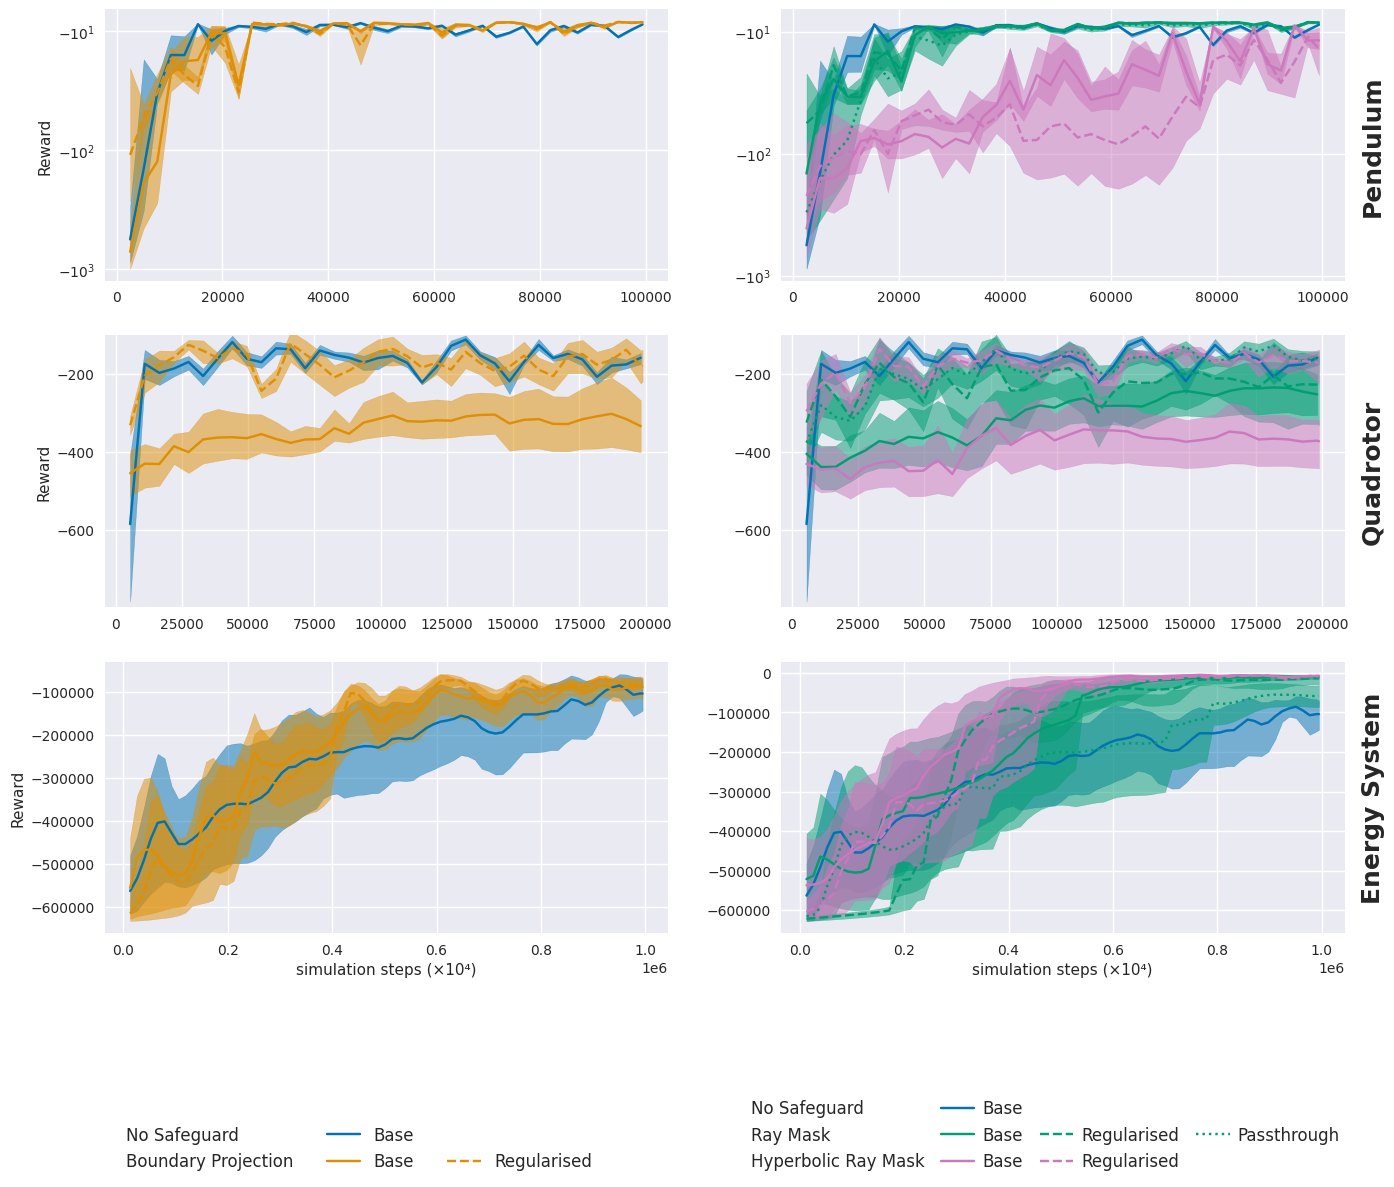

In [64]:
plt.style.use("seaborn-v0_8")

colors = {
    "No Safeguard": sns.color_palette("colorblind")[0],
    "Boundary Projection": sns.color_palette("colorblind")[1],
    "Ray Mask": sns.color_palette("colorblind")[2],
    "Hyperbolic Ray Mask": sns.color_palette("colorblind")[4],
}

styles = {
    "Base": "solid",
    "Regularised": "dashed",
    "Passthrough": "dotted",
}

row = {
    "Pendulum": 0,
    "Quadrotor": 1,
    "Energy System": 2,
}

fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=False, sharey=False)

for ax, title in zip(axes[:,1], ["Pendulum", "Quadrotor", "Energy System"]):
    ax.text(1.05, 0.5, title, va='center', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=18, fontweight='bold')
for ax in axes[:,0]:
    ax.set_ylabel("Reward")
for ax in axes[-1, :]:
    ax.set_xlabel("simulation steps (×10⁴)")
for ax in axes[0, :]:
    ax.set_yscale("symlog")
for ax in axes[1, :]:
    ax.set_ylim([-800, -100])
    ax.set_yticks([-600, -400, -200])

for env in env_translation.keys():
    for safeguard in safeguard_translation.keys():
        if safeguard == "Ray Mask Orthogonal":
            continue
        x = results[env]["SHAC"][safeguard]["steps"]
        y, y_lower, y_upper = bootstrap_mean_ci(results[env]["SHAC"][safeguard]["reward"])
        if len(x) != len(y):
            x = x[:-1]
        if safeguard == "No Safeguard":
            label = "Base"
            base = "No Safeguard"
        else:
            label = re.search(r'\b(\w+)\b$', safeguard).group(1)
            base = re.sub(r'\s*\b\w+\b$', '', safeguard)

        style = styles[label]
        color = colors[base]

        plot_axes = []
        if "Boundary Projection" in safeguard:
            plot_axes += [axes[row[env], 0]]
        elif "Ray Mask" in safeguard:
            plot_axes += [axes[row[env], 1]]
        elif "No Safeguard" in safeguard:
            plot_axes += [axes[row[env], 0]]
            plot_axes += [axes[row[env], 1]]

        for ax in plot_axes:
            ax.plot(x, y, color=color, label=label, linestyle=style)
            ax.fill_between(x, y_lower, y_upper, color=color, alpha=0.5)

ns_handle = mlines.Line2D([], [], color=colors["No Safeguard"], linestyle=styles["Base"])
bp_base_handle = mlines.Line2D([], [], color=colors["Boundary Projection"], linestyle=styles["Base"])
bp_reg_handle = mlines.Line2D([], [], color=colors["Boundary Projection"], linestyle=styles["Regularised"])
placeholder = mlines.Line2D([], [], color='none', marker='none', linestyle='none')

left_handles = [
    placeholder, placeholder, ns_handle,
    bp_base_handle, placeholder, bp_reg_handle,
]
left_labels = [
    "No Safeguard", "Boundary Projection",
    "Base", "Base",
     "", "Regularised",
]

fig.legend(
    handles=left_handles,
    labels=left_labels,
    loc="lower left",
    bbox_to_anchor=(0.1, -0.1),
    fontsize=12,
    ncol=3,
)

# Right Legend
rm_base_handle = mlines.Line2D([], [], color=colors["Ray Mask"], linestyle=styles["Base"])
rm_reg_handle = mlines.Line2D([], [], color=colors["Ray Mask"], linestyle=styles["Regularised"])
rm_pt_handle = mlines.Line2D([], [], color=colors["Ray Mask"], linestyle=styles["Passthrough"])
hrm_base_handle = mlines.Line2D([], [], color=colors["Hyperbolic Ray Mask"], linestyle=styles["Base"])
hrm_reg_handle = mlines.Line2D([], [], color=colors["Hyperbolic Ray Mask"], linestyle=styles["Regularised"])

right_handles = [
    placeholder, placeholder, placeholder,
    ns_handle, rm_base_handle, hrm_base_handle,
    placeholder, rm_reg_handle, hrm_reg_handle,
    placeholder, rm_pt_handle, placeholder,
]
right_labels = [
    "No Safeguard", "Ray Mask", "Hyperbolic Ray Mask",
    "Base", "Base", "Base",
    "", "Regularised", "Regularised",
    "", "Passthrough",  "",
]

fig.legend(
    handles=right_handles,
    labels=right_labels,
    loc="lower center",
    bbox_to_anchor=(0.7, -0.1),
    fontsize=12,
    ncol=4,
    handletextpad=0.5,
    columnspacing=1.0,
)

plt.show()